In [5]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xarray as xa
import h5py    
import pandas as pd
import os
import re
import yaml

fig_path = '/home/dm/uni/ccees/seminar/analysis/figures/'
name_convention = 'ERs_swmean_finf_rinits_rpop-'

config_file = '../config/run_cfg.yml'

#### Load the Config File
But first replace ! for sweep with # 

In [6]:
%%bash -s "$config_file" 
sed -i 's/!/#/g' $1

Load the yml file. 

In [7]:
with open(config_file, 'r') as f:
    cfg = yaml.load(f)

<ipython-input-7-d3c0db5e0f73>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(f)


Print out the cfg file:

In [8]:
cfg

{'parameter_space': {'num_steps': 6000,
  'write_every': 1,
  'seed': {'default': 42,
   'values': [42,
    2,
    50,
    80,
    100,
    200,
    300,
    400,
    1000,
    240,
    1020,
    2010,
    43,
    3,
    51,
    81,
    101,
    201,
    301,
    401,
    1001,
    241,
    1021,
    2011]},
  'MyFancySeirModel': {'create_graph': {'model': 'ErdosRenyi',
    'num_vertices': 50,
    'mean_degree': {'default': 20, 'values': [2, 5, 10, 15, 20, 50, 80]}},
   'random_population': {'enabled': True,
    'randomize': ['S', 'E', 'I', 'R'],
    'distribution': 'exponential',
    'lambda': 8.0},
   'random_infection_parameters': {'enabled': False,
    'randomize': ['beta'],
    'enable_variance_around_mean': True,
    'percentage': 0.1},
   'init_random_weight': True,
   'init_weight': 0.01,
   's_weight': 1,
   'e_weight': 1,
   'i_weight': 1,
   'r_weight': 1,
   'd_weight': 0}}}

Get seeds and vertices

In [247]:
svar_name = 'mean_degree'
svars = np.array(cfg['parameter_space']['MyFancySeirModel']['create_graph'][svar_name]['values'])

if svar_name == 'mean_degree':
    num_vertices = cfg['parameter_space']['MyFancySeirModel']['create_graph']['num_vertices']
elif svar_name == 'num_vertices':
    mean_degree = cfg['parameter_space']['MyFancySeirModel']['create_graph']['mean_degree']
    
seeds = np.array(cfg['parameter_space']['seed']['values'])
num_steps = cfg['parameter_space']['num_steps']

In [79]:
svars

array([ 2,  5, 10, 15, 20, 50, 80])

In [80]:
no_seeds = len((seeds))
print(no_seeds)
no_svar = len((svars))
print(no_svar)

24
7


In [12]:
universe_paths =  !find uni*/data*

In [93]:
def choose_seed_svar(se, sv):
    isv = np.where(svars == sv)[0][0]
    ise = np.where(seeds == se)[0][0]
    return isv * len(seeds) + ise

In [120]:
def smallestDivisor(n): 
  
    # if divisible by 2 
    if (n % 2 == 0): 
        return 2; 
  
    # iterate from 3 to sqrt(n) 
    i = 3;  
    while(i * i <= n): 
        if (n % i == 0): 
            return i; 
        i += 2; 
  
    return n;

In [249]:
def plot_inf_seed_comp(data, ref_data, SE, SV):
    
    IDX = []
    cols = smallestDivisor(len(SE))
    rows = int(len(SE) / cols)
    
    for (se, sv) in zip(SE, SV):
        IDX.append(choose_seed_svar(se, sv))
        
    SIM = []
    REF = []
    
    for idx in IDX:
        SIM.append(data[idx])
        REF.append(ref_data[:, :, idx])
    
    fig, ax = plt.subplots(rows, cols, figsize=(15,10))
    if rows == cols == 1:
        ax.set_title('Seed: {}, {}: {}'.format(SE[0], svar_name, SV[0]))
        for i in range(SIM[0].shape[1]):
            ax.plot(SIM[0][:, i], label='{}'.format(comps[i]))
        for i in range(REF[0].shape[1]):
            ax.plot(REF[0][:, i], '--', label='{} ref'.format(ref_names[i]))
        ax.legend(loc='upper right')
    else:
        ax = ax.flatten()
        for (j, a, sim) in zip(range(len(SIM)), ax, SIM):
            a.set_title('Seed: {}, {}: {}'.format(SE[j], svar_name, SV[j]))
            for i in range(sim.shape[1]):
                a.plot(sim[:, i], label='{}'.format(comps[i]))

        for (a, ref) in zip(ax, REF):
            for i in range(ref.shape[1]):
                a.plot(ref[:, i], '--', label='{} ref'.format(ref_names[i]))
        for a in ax:
            a.legend(loc='upper right')
    
    if svar_name == 'mean_degree':
        fig.suptitle('Seeds: {}, num_vertices: {}'.format(no_seeds, num_vertices))
    elif svar_name == 'num_vertices':
        fig.suptitle('Seeds: {}, mean_degree: {}'.format(no_seeds, mean_degree))
        
    return fig, ax

In [15]:
universe_data = []
for uni in universe_paths:
    file_name = uni
    universe_data.append(h5py.File(uni , 'r+'))

no_universe = len(universe_data)

In [17]:
ref_data_shape = universe_data[0]['MyFancySeirModel']['SEIR_reference'].shape
ref_data = np.empty((ref_data_shape[0], ref_data_shape[1], no_universe ))
for i in range(no_universe):
    ref_data[:, :, i] = universe_data[i]['MyFancySeirModel']['SEIR_reference'][()] 

In [18]:
#comps = ['D', 'E', 'I', 'N', 'R', 'S']
comps = ['D', 'E', 'I', 'R', 'S']
no_comps = len(comps)
sim_data = []
no_uni_vertices = np.empty(no_universe)
for i in range(no_universe):
    shape = universe_data[i]['MyFancySeirModel']['g_static']['D'].shape
    no_uni_vertices[i] = shape[1]
    comp_data = np.empty((shape[0], shape[1],  len(comps)))
    for (j, comp) in enumerate(comps):
        comp_data[:, :, j] = universe_data[i]['MyFancySeirModel']['g_static'][comp]
    sim_data.append(comp_data)

In [19]:
sim_Sdata = []

for uni in range(no_universe):
    sim_Sdata.append(np.sum(sim_data[uni], axis=1))

#### Infection Wave function

In [20]:
def find_infection_wave(I_ts, idx = 0 ):
    tmax = idx + np.argmax(I_ts[idx:])
    vmax = I_ts[int(tmax)]
    return [tmax, vmax]
idx_secwave = 2000

Average over seeds:

In [21]:
avg_sim_Sdata = []
std_sim_Sdata = []
first_infection_wave = np.empty((no_svar, 2, no_seeds))
second_infection_wave = np.empty((no_svar, 2, no_seeds))
for v in range(no_svar):
    shape = (num_steps + 1, no_comps, no_seeds)
    V = np.empty(shape)
    
    for s in range(no_seeds):
        V[:, :, s] = sim_Sdata[v*no_seeds + s]
        first_infection_wave[v, :, s] = find_infection_wave(V[:, 2, s])
        second_infection_wave[v, :, s] = find_infection_wave(V[:, 2, s], idx=idx_secwave)
    
    mean = np.mean(V, axis=2)
    std = np.std(V, axis=2)
    
    avg_sim_Sdata.append(mean)
    std_sim_Sdata.append(std)

In [22]:
mean_first_infection_wave = np.mean(first_infection_wave, axis=2)
mean_second_infection_wave = np.mean(second_infection_wave, axis=2)
std_first_infection_wave = np.std(second_infection_wave, axis=2)
std_second_infection_wave = np.std(second_infection_wave, axis=2)

##### Average and Std of SEIR reference model

In [23]:
avg_ref_data= []
std_ref_data = []
ref_first_infection_wave = np.empty((no_svar, 2, no_seeds))
ref_second_infection_wave = np.empty((no_svar, 2, no_seeds))

for v in range(no_svar):
    p = v * no_seeds
    for s in range(no_seeds):
        ref_first_infection_wave[v, :, s] = find_infection_wave(ref_data[:, 2, v*no_seeds + s])
        ref_second_infection_wave[v, :, s] = find_infection_wave(ref_data[:, 2, v*no_seeds + s], idx=idx_secwave)
        
    avg_ref_data.append(np.mean(ref_data[:, :, p:p+no_seeds], axis=2))
    std_ref_data.append(np.std(ref_data[:, :, p:p+no_seeds], axis=2))

In [24]:
mean_ref_first_infection_wave = np.mean(ref_first_infection_wave, axis=2)
mean_ref_second_infection_wave = np.mean(ref_second_infection_wave, axis=2)
std_ref_first_infection_wave = np.std(ref_second_infection_wave, axis=2)
std_ref_second_infection_wave = np.std(ref_second_infection_wave, axis=2)

In [25]:
mean_ref_inv = np.mean(1/ ref_first_infection_wave, axis=2)
std_ref_inv = np.std(1/ ref_first_infection_wave, axis=2)

mean_ref_inv_sec = np.mean(1/ ref_second_infection_wave, axis=2)
std_ref_inv_sec = np.std(1/ ref_second_infection_wave, axis=2)

In [58]:
mxy_first = np.mean(first_infection_wave / ref_first_infection_wave - 1, axis=2)
sxy_first = np.std(first_infection_wave / ref_first_infection_wave - 1, axis=2)

mxy_second = np.mean(second_infection_wave / ref_second_infection_wave - 1, axis=2)
sxy_second = np.std(second_infection_wave / ref_second_infection_wave - 1, axis=2)

###  Number of Vertices

In [29]:
ref_names = ['S', 'E', 'I', 'R', 'D']

#### Confidence Interval Total Population Plot

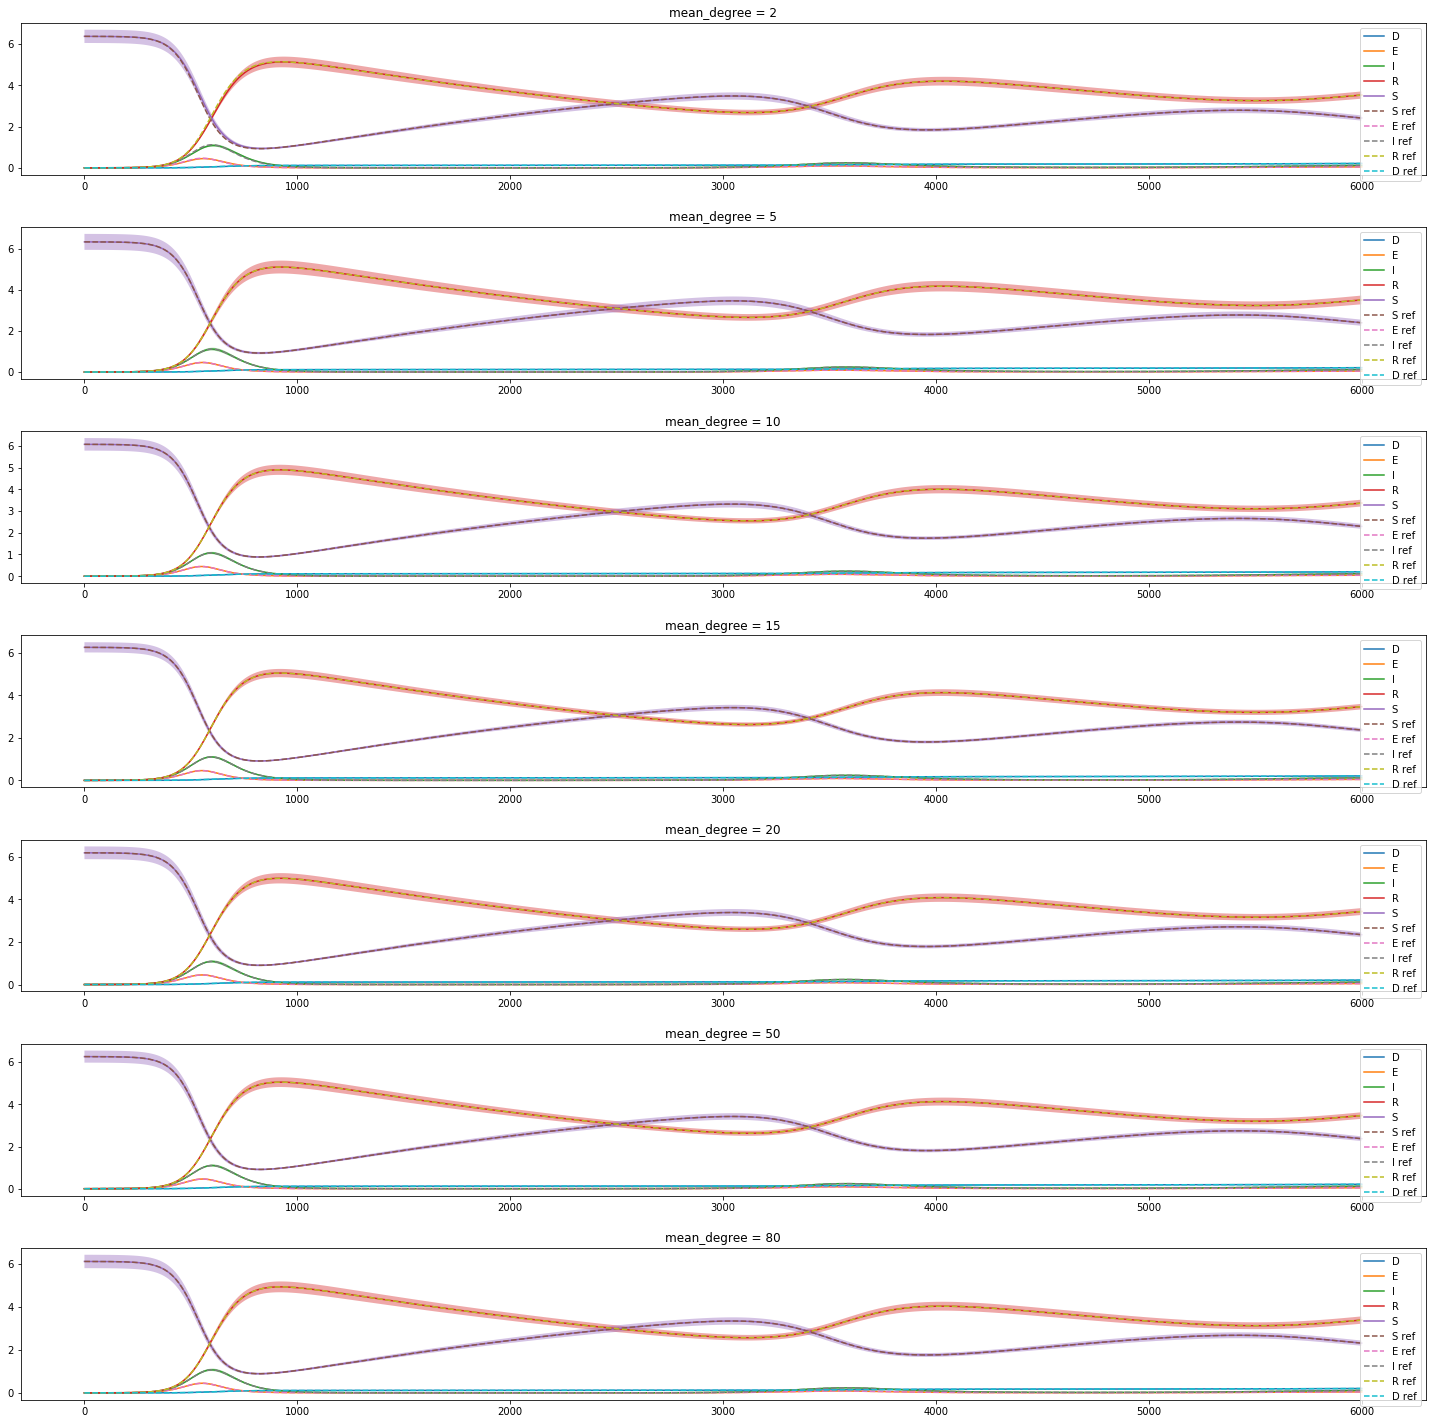

In [30]:
vertsweep_fig, ax = plt.subplots(no_svar, 1, figsize=(20,20))
ax = ax.flatten()

for sv in range(no_svar):
    for comp in range(len(comps)):
        ci = 1.96 * std_sim_Sdata[sv][:, comp] / np.sqrt(no_seeds)
        y = avg_sim_Sdata[sv][:,comp]
        ax[sv].plot(y, label=comps[comp])
        ax[sv].fill_between(np.arange(num_steps+1),(y-ci), (y+ci), alpha=0.4)
        
        
    
    for i in range(ref_data.shape[1]):
        ax[sv].plot(avg_ref_data[sv][:, i], '--', label='{} ref'.format(ref_names[i]))
    
    ax[sv].set_title('{} = {}'.format(svar_name,svars[sv]))
    ax[sv].legend()
        
plt.tight_layout()

### Dependency of Infection Waves on Vertices in Network

#### Visualize Infection Waves for all vertices

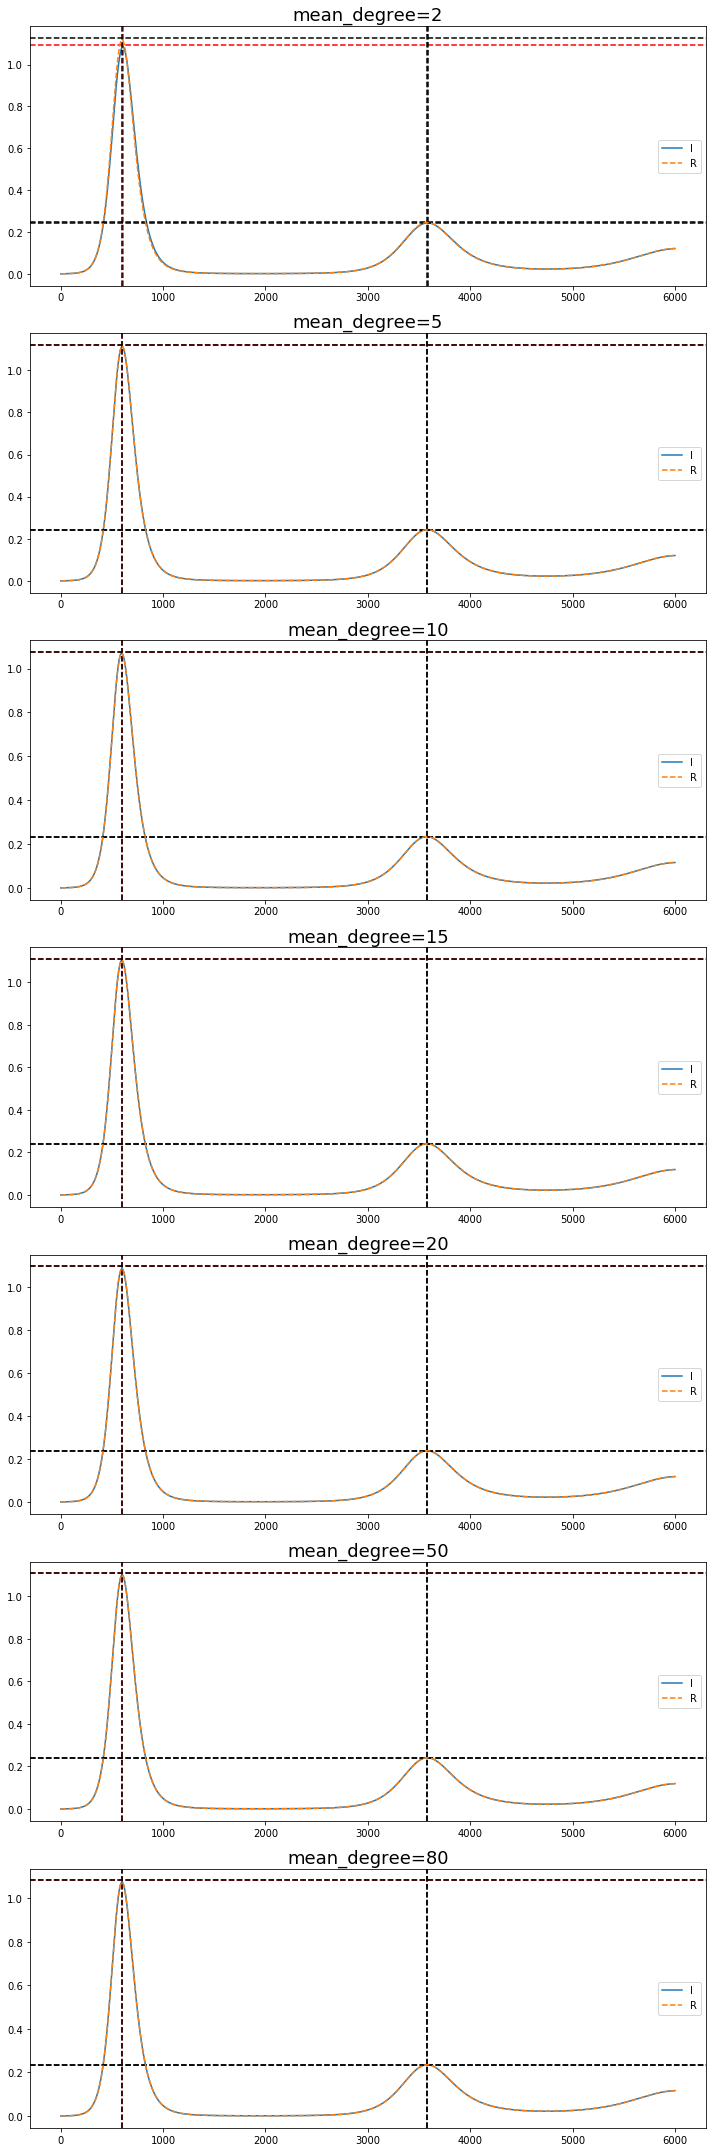

In [245]:
svsweep_fig, ax = plt.subplots(no_svar, 1, figsize=(10,30))
ax = ax.flatten()

for sv in range(no_svar):
    comp=2
    ax[sv].plot(avg_sim_Sdata[sv][:, comp], label=comps[comp])
    ax[sv].axhline(mean_first_infection_wave[sv, 1], ls='--',ms=1, color='red' )
    ax[sv].axvline(mean_first_infection_wave[sv, 0], ls='--',ms=1, color='red' )
    
    ax[sv].axhline(mean_second_infection_wave[sv, 1], ls='--',ms=1, color='black' )
    ax[sv].axvline(mean_second_infection_wave[sv, 0], ls='--',ms=1, color='black' )
    
    ax[sv].axhline(mean_ref_first_infection_wave[sv, 1], ls='--',ms=1, color='black' )
    ax[sv].axvline(mean_ref_first_infection_wave[sv, 0], ls='--',ms=1, color='black' )
    
    ax[sv].axhline(mean_ref_second_infection_wave[sv, 1], ls='--',ms=1, color='black' )
    ax[sv].axvline(mean_ref_second_infection_wave[sv, 0], ls='--',ms=1, color='black' )
    ax[sv].plot(avg_ref_data[sv][:, comp], '--', label='{}'.format(ref_names[i]))
    
    ax[sv].set_title('{}={}'.format(svar_name,svars[sv]))
    ax[sv].legend()
        
plt.tight_layout()

plt.savefig(fig_path + name_convention + 'maxcheck.pdf')

#### Compare Infection Wave Positions and Severity

In [232]:
#plt.rc('axes', titlesize=18)
#plt.rc('axes', titlesize=18)
#maxI_fig, ax = plt.subplots(2, 2, figsize=(12,8))
#ax = ax.flatten()
#
#ax[0].errorbar(svars, mean_first_infection_wave[:, 0], yerr= 1.96 * std_first_infection_wave[:, 0], label='graph', fmt='o')
#ax[2].errorbar(svars, mean_first_infection_wave[:, 1], yerr=1.96 * std_first_infection_wave[:, 1], fmt='o', label='graph')
#
#ax[0].scatter(svars, mean_ref_first_infection_wave[:, 0], label='ref', color='orange')
#ax[2].scatter(svars, mean_ref_first_infection_wave[:, 1], label='ref', color='orange')
#
#ax[1].errorbar(svars, mean_second_infection_wave[:, 0], yerr= 1.96 * std_second_infection_wave[:, 0], label='graph', fmt='o')
#ax[3].errorbar(svars, mean_second_infection_wave[:, 1], yerr=1.96 * std_second_infection_wave[:, 1], fmt='o', label='graph')
#
#ax[1].scatter(svars, mean_ref_second_infection_wave[:, 0], label='ref', color='orange')
#ax[3].scatter(svars, mean_ref_second_infection_wave[:, 1], label='ref', color='orange')
#
#ax[0].legend()
#ax[1].legend()
#ax[2].legend()
#ax[3].legend()
#
#ax[0].set_title("First Wave")
#ax[1].set_title("Second Wave")
#
#for i in range(4):
#    ax[i].set_xlabel('No. of Vertices')
#
#plt.tight_layout()

Calculate the standard deviation of product:

In [47]:
def stdxy(meanx, meany, stdx, stdy):
    return np.sqrt(meanx**2 * stdy**2 + meany**2 * stdx**2 + stdx**2 * stdy**2)

Show the percentage difference to the SEIR reference model:

In [233]:
#plt.rc('axes', labelsize=13)
#plt.rc('axes', titlesize=18)
#maxIratioref_fig, ax = plt.subplots(2, 2, figsize=(12,8))
#ax = ax.flatten()
#
#ax[0].errorbar(svars, mean_first_infection_wave[:, 0] * mean_ref_inv[:, 0] - 1,\
#              yerr = stdxy(mean_first_infection_wave[:, 0], mean_ref_inv[:, 0], std_first_infection_wave[:, 0], std_ref_inv[:, 0]), fmt='o')
#
#ax[2].errorbar(svars, mean_first_infection_wave[:, 1] * mean_ref_inv[:, 1] - 1,\
#              yerr = stdxy(mean_first_infection_wave[:, 1], mean_ref_inv[:, 1], std_first_infection_wave[:, 1], std_ref_inv[:, 1]), fmt='o')
#
#ax[1].errorbar(svars, mean_second_infection_wave[:, 0] * mean_ref_inv_sec[:, 0] - 1,\
#              yerr = stdxy(mean_second_infection_wave[:, 0], mean_ref_inv_sec[:, 0], std_second_infection_wave[:, 0], std_ref_inv_sec[:, 0]), fmt='o')
#
#
#ax[3].errorbar(svars, mean_second_infection_wave[:, 1] * mean_ref_inv_sec[:, 1] - 1,\
#              yerr = stdxy(mean_second_infection_wave[:, 1], mean_ref_inv_sec[:, 1], std_second_infection_wave[:, 1], std_ref_inv_sec[:, 1]), fmt='o')
#
#
#
#ax[0].set_title("First Wave")
#ax[1].set_title("Second Wave")
#ax[0].set_ylabel(r"$\frac{T_{max}}{T^{ref}_{max}} - 1$")
#ax[2].set_ylabel(r"$\frac{I_{max}}{I^{ref}_{max}} - 1$")
#
#for i in range(4):
#    ax[i].set_xlabel('No. of Vertices')
#    ax[i].grid()
#
#plt.tight_layout()
#
#plt.savefig(fig_path + name_convention + 'more_seed' + 'waves.pdf')

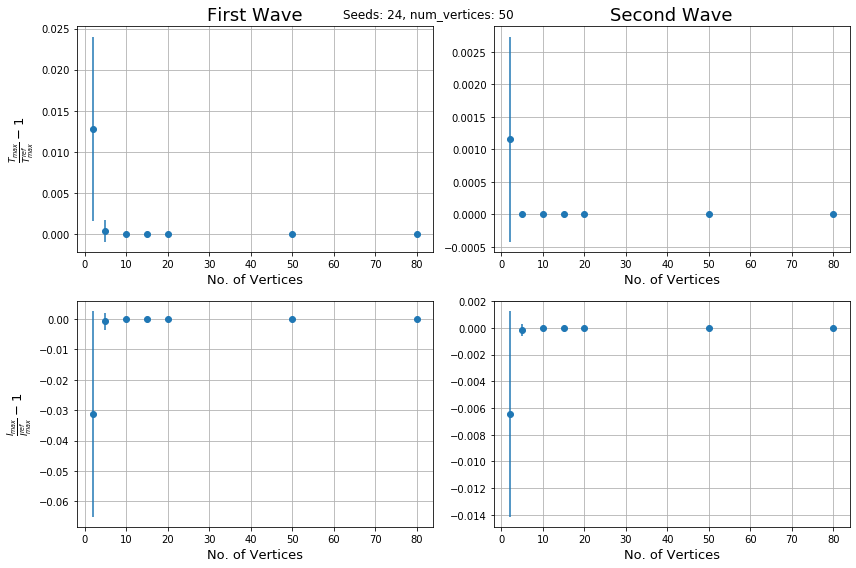

In [252]:
plt.rc('axes', labelsize=13)
plt.rc('axes', titlesize=18)
maxIratioref_fig, ax = plt.subplots(2, 2, figsize=(12,8))
ax = ax.flatten()


ax[0].errorbar(svars, mxy_first[:, 0], yerr = 1.96 * sxy_first[:, 0], fmt='o')
ax[1].errorbar(svars, mxy_second[:, 0], yerr = 1.96 * sxy_second[:, 0], fmt='o')

ax[2].errorbar(svars, mxy_first[:, 1], yerr = 1.96 * sxy_first[:, 1], fmt='o')
ax[3].errorbar(svars, mxy_second[:, 1], yerr = 1.96 * sxy_second[:, 1], fmt='o')


for i in range(4):
    ax[i].set_xlabel('No. of Vertices')
    ax[i].grid()


ax[0].set_title("First Wave")

ax[1].set_title("Second Wave")
ax[0].set_ylabel(r"$\frac{T_{max}}{T^{ref}_{max}} - 1$")
ax[2].set_ylabel(r"$\frac{I_{max}}{I^{ref}_{max}} - 1$")


if svar_name == 'mean_degree':
    maxIratioref_fig.suptitle('Seeds: {}, num_vertices: {}'.format(no_seeds, num_vertices))
elif svar_name == 'num_vertices':
    maxIratioref_fig.suptitle('Seeds: {}, mean_degree: {}'.format(no_seeds, mean_degree))
plt.tight_layout()

plt.savefig(fig_path + name_convention + 'wavecomp.pdf')

#### Plot individual seeds:

In [189]:
seeds

array([  42,    2,   50,   80,  100,  200,  300,  400, 1000,  240, 1020,
       2010,   43,    3,   51,   81,  101,  201,  301,  401, 1001,  241,
       1021, 2011])

In [229]:
svars

array([ 2,  5, 10, 15, 20, 50, 80])

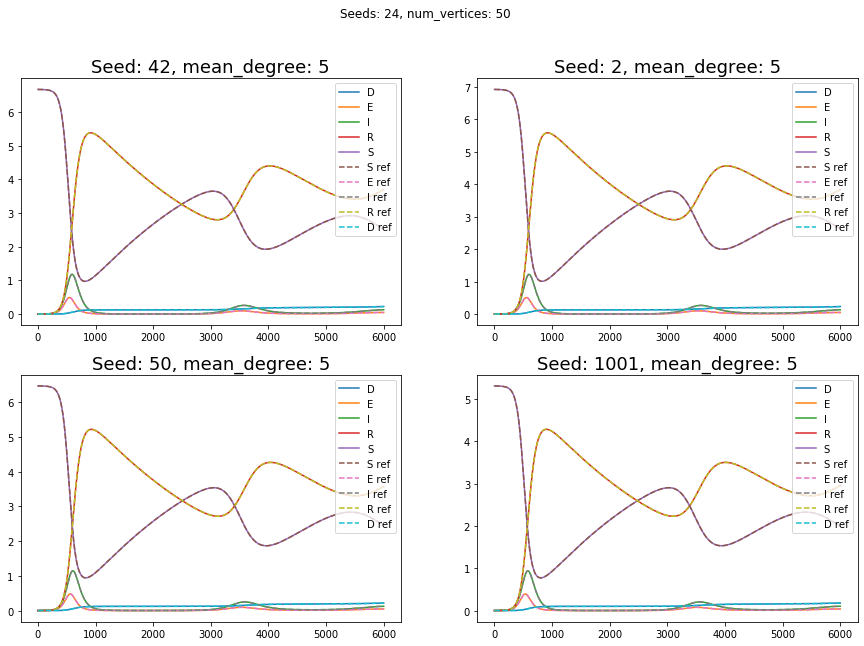

In [250]:
f1, ax1 = plot_inf_seed_comp(sim_Sdata, ref_data, [42, 2, 50, 1001], [5, 5, 5, 5])

In [244]:
for i in range(len(ax1)):
    ax1[i].set_xlim(0, 1000)
    ax1[i].set_ylim(0, 2)
f1
f1.savefig(fig_path + name_convention + 'seedcomp.pdf')